<a href="https://colab.research.google.com/github/clint-bg/demos/blob/main/PaintCanFlame/PaintCanFlame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paint Can Flame and Explosion 
Clint Guymon<br>
BYU Chemical Engineering

A one gallon paint can is filled with a flammable gas (methane). There is a small hole in the side and a small hole in the top. After filling the paint can with the flammable gas, the fumes/gas is ignited above the can and a large flame is visible. Air is pulled into the can and mixes with the flammble gas and the concentration of the flammable gas and the flame size decreases. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import param

![](https://raw.githubusercontent.com/clint-bg/demos/main/PaintCanFlame/PaintCanImage.png)

## Material Balances

The change in the internal composition of the can can be estimated from a material balance where:<br>
accumulation = in - out + generation - consumption<br><br>
The above equation can be written for both the flammable component (methane) and the air component inside the can. There isn't any generation or consumption of air or methane inside the can so those terms are zero. The accumulation term is a derivative. In symbolic notation the above equation is: <br>
\begin{align}
dn_f/dt = \dot{n}^{in}_f - \dot{n}^{out}_f, \\
dn_a/dt = \dot{n}^{in}_a - \dot{n}^{out}_a
\end{align} <br>
The dot above the n indicates a rate so that $\dot{n}$ is the change in moles per second from the flow into or out of the can. The derivatives, $dn/dt$, is the change in moles inside the can of the flammable or air component per time. These derivatives are important as they can be integrated numerically to obtain the actual number of moles as a function of time inside the can. With that information, the expected time before the flame is expected to go out or transition inside the can can be estimated. Similarly, the time at which a flammable concentration is reached inside the can can be determined. <br><br>

There isn't flow of flammable gas into the can so the $\dot{n}^{in}_f$ term is zero. The other terms can be estimated:
- The flow out of the hole can be estimated from buoyancy effects (based on the concentration of the gas inside the can assumed to be perfectly mixed). Effect of diffusion can also be included.
- The flow into the can is the same as the outflow except that the composition remains at 100% air.


## Outflow Approximation

The outflow from the can is based on the buoyancy and diffusion of the internal gases. Determining that rate from first principles can be complex so we'll attempt an estimate. We'll now how accurate the estimate if the model accurately predicts the real world result: time to explosion from ignition to explosion of the gases inside the paint can. <br><br>

Approximation: A sphere exits the top of the can with diamter equal to the orifice diameter and proceeds to accelerate upwards based on the buoyancy force. The buoyancy force is assumed to proceed for 1/3 of a second before it disperses (estimate I made up, we'll see if it's right). Based on that force and time of acceleration, a rate of flow from the orifice can be estimated. Additive to that estimate is from the molar flow from the orifice based on the diffusivity of methane in air. The equations used are not given here but listed below.

![](https://raw.githubusercontent.com/clint-bg/demos/main/PaintCanFlame/Bouyancy-1.png)

## Object Oriented Model

Natural gas is introduced to the can with a constant flow rate at the hole in the side of the can. The below equations are used to predict the time it takes to fill and empty the can. 

Two conditions must be met for there to be a rapid combustion event (explosion) within the can:
- The flow rate must be less than the flame propagation speed
- The concentration within the can must be in the flammability limit

In [3]:
class Can(param.Parameterized):
  'Model for filling can with a gas'
  Rg = param.Number(8.314,doc='Gas constant (Jol/mol/K)',constant=True)
  ch4mw = param.Number(0.016,doc='methane molecular weight (kg/mol)',constant=True)
  airmw = param.Number(0.029,doc='air molecular weight (kg/mol)',constant=True)
  Vol = param.Number(0.00379,doc='Volume of 1 gallon in m3 (m3)')
  Patm = param.Number(85000,doc='Atmospheric pressure (Pa)')
  T = param.Number(295,doc='Temperature (K)')
  nfdotin = param.Number(24,doc='Flow speed of flammable gas into can (in/s)')
  tophole = param.Number(0.3*0.0254,doc='Top hole diameter (m)')

  #solved for parameters
  t = param.List(np.linspace(0,800,600).tolist()) #list of times to solve for, converted to a list

  def rho_air(self): #kg/m3
    return self.Patm/(self.Rg*self.T)*self.airmw #ideal gas law
  
  def rho_ch4(self): #kg/m3
    return self.Patm/(self.Rg*self.T)*self.ch4mw

  def inletflow(self): #from source
    return (self.nfdotin*0.25*np.pi*(3/8)**2)/61023*self.rho_ch4()/self.ch4mw #'Molar flow rate of flammable gas  (mol/s)'
  
  def outlet(self,fracf): #outlet flow from top hole on can due to bouyancy (ignoring diffusion and the effects of the bouyancy of the heating area above the hole) 
    #dvdt = -rhoCH4*V*g+rhoAir*V*g, assuming the bouyancy force last for 1 sec through the tophole
    rho = fracf*self.rho_ch4()+(1-fracf)*self.rho_air();  mw = fracf*self.ch4mw+(1-fracf)*self.airmw;
    accel = (self.rho_air()-rho)*9.81/rho #m/s**2
    #molesinbubble = rho/mw*4/3*np.pi*(self.tophole/2)**3
    molesincyl = rho/mw*self.tophole*0.25*np.pi*self.tophole**2
    exittime = np.sqrt(self.tophole*2/accel) #time to exit the hole (with above acceleration starting at zero at the exit)
    #now include diffusion
    methaneinairD = 0.221/(1e4) #m**2/s
    fluxD = rho*methaneinairD/mw*(fracf-0)/self.tophole*0.25*np.pi*self.tophole**2 #mol/s, diffusion length assumed to be one hole diameter
    fluxv = fluxD*mw/rho/(0.25*np.pi*self.tophole**2) #m/s

    #now include buoyancy from flame size (an eductor effect)
    #assume flame height or density corresponds linearly to the fraction of methane in the can
    rhoHot = rho*298/(1100*fracf + 298*(1-fracf))
    accelHot = (self.rho_air()-rhoHot)*9.81/rhoHot #m/s**2
    exittimeHot = np.sqrt(self.tophole*2/accelHot)

    vel = self.tophole/exittime + fluxv + self.tophole/exittimeHot*0 #m/s
    flow = molesincyl/exittime + fluxD + molesincyl/exittimeHot*0 #mol/sec
    return [vel,flow]

  def totalmoles(self): #moles of air
    return self.Patm*self.Vol/(self.Rg*self.T)

  def derivs_fill(self,y,t): #return derivatives for dependent variables for filling
    #dn/dt = nfdotin - nout 
    #dnf/dt = nfdotin - nfout
    #dna/dt = naout

    nf,na = y; fracf = nf/(na+nf); flow = self.inletflow()
    dnfdt = flow - fracf*flow
    dnadt = -(1-fracf)*flow
    dydt = [dnfdt,dnadt]
    return dydt

  def derivs_empty(self,y,t): #derivatives for emptying
    #dn/dt = nfin - nout 
    #dnf/dt = - nfout
    #dna/dt = nain - naout

    nf,na = y; fracf = nf/(na+nf); flow = self.outlet(fracf)[1]
    dnfdt = - flow*fracf
    dnadt = flow - (1-fracf)*flow
    dydt = [dnfdt,dnadt]
    return dydt
  
  def solve(self): #solves for each time step
    self.fill = odeint(self.derivs_fill,[0,self.totalmoles()],self.t)
    self.empty = odeint(self.derivs_empty,[self.totalmoles(),0],self.t)

In [4]:
paintcan = Can()

In [5]:
paintcan.solve()

In [6]:
fracff = paintcan.fill[:, 0]/(paintcan.fill[:,1]+paintcan.fill[:,0])
fracfe = paintcan.empty[:, 0]/(paintcan.empty[:,1]+paintcan.empty[:,0])

In [7]:
x = paintcan.t
upperfl = [0.15 for each in x]; lowerfl = [0.05 for each in x]

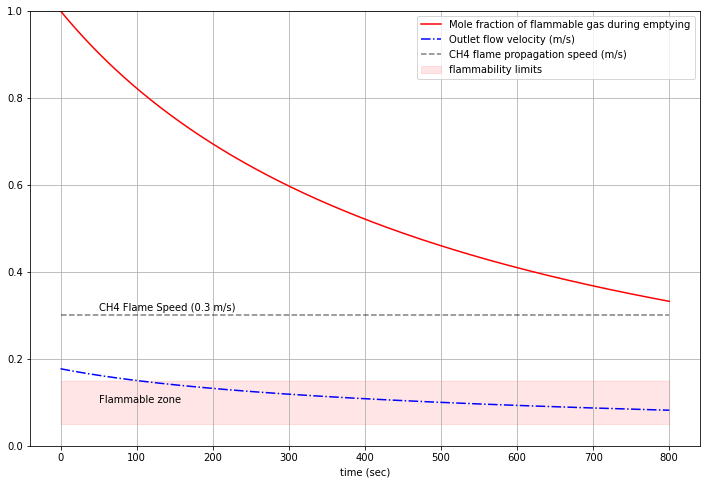

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
#plt.plot(can0.t, fracff, label='Mole fraction of flammable gas during filling')
plt.plot(paintcan.t, fracfe,'r', label='Mole fraction of flammable gas during emptying')
plt.plot(paintcan.t,paintcan.outlet(fracfe)[0],'b-.', label='Outlet flow velocity (m/s)')
plt.plot(paintcan.t,[0.3 for each in paintcan.t],'k--',alpha=0.5,label='CH4 flame propagation speed (m/s)')
ax.fill_between(x,upperfl,lowerfl,color='r',alpha=0.1,label='flammability limits')
plt.legend(loc='best')
plt.xlabel('time (sec)')
ax.set_ylim([0, 1])
plt.text(50,0.1,'Flammable zone');plt.text(50,0.31,'CH4 Flame Speed (0.3 m/s)')
plt.grid()
plt.show()

In [14]:
#mass of oxygen and methane that react stoichiometrically once the flammability limit is reached
molesofO2 = paintcan.totalmoles()*(1-0.15)*0.21
reqMolCH4 = 0.5*molesofO2
molesofO2*32 + reqMolCH4*16

0.9378304106204358